In [35]:
import cv2               # OpenCV per computer vision
import numpy as np       # NumPy per gestione array numerici
import matplotlib.pyplot as plt  # Matplotlib per visualizzazioni (se necessario)

# Parametri globali
MIN_MATCH_COUNT = 4      # Numero minimo di match per tentare il riconoscimento
MIN_INLIERS = 8          # Minimo numero di inlier (match coerenti) per accettare un rilevamento


In [36]:
# Identificativi dei file dei modelli da utilizzare
model_ids = ["0", "1", "11", "19", "24", "25", "26"]

# Dizionari per immagini modelli e scene
model_images = {}      # immagini modello (scala di grigi)
scene_images = {}      # immagini di scena (a colori per visualizzazione)
scene_images_gray = {} # immagini di scena in scala di grigi per elaborazione

# Caricamento delle immagini modello
for mid in model_ids:
    img = cv2.imread(f"models/{mid}.jpg", cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Immagine modello {mid}.jpg non trovata.")
    else:
        model_images[mid] = img

# Caricamento delle immagini di scena
scene_files = [f"e{i}.png" for i in range(1, 6)]
for sf in scene_files:
    img_color = cv2.imread(f"scenes/{sf}", cv2.IMREAD_COLOR)
    if img_color is None:
        print(f"Immagine di scena {sf} non trovata.")
    else:
        scene_images[sf] = img_color
        # Convertiamo anche in scala di grigi per il processamento
        scene_images_gray[sf] = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# Verifica: stampa del numero di immagini caricate
print(f"Modelli caricati: {len(model_images)}")
print(f"Scene caricate: {len(scene_images)}")
# Identificativi dei file dei modelli da utilizzare
model_ids = ["0", "1", "11", "19", "24", "25", "26"]

# Dizionari per immagini modelli e scene
model_images = {}      # immagini modello (scala di grigi)
scene_images = {}      # immagini di scena (a colori per visualizzazione)
scene_images_gray = {} # immagini di scena in scala di grigi per elaborazione

# Caricamento delle immagini modello
for mid in model_ids:
    img = cv2.imread(f"models/{mid}.jpg", cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Immagine modello {mid}.jpg non trovata.")
    else:
        model_images[mid] = img

# Caricamento delle immagini di scena
scene_files = [f"e{i}.png" for i in range(1, 6)]
for sf in scene_files:
    img_color = cv2.imread(f"scenes/{sf}", cv2.IMREAD_COLOR)
    if img_color is None:
        print(f"Immagine di scena {sf} non trovata.")
    else:
        scene_images[sf] = img_color
        # Convertiamo anche in scala di grigi per il processamento
        scene_images_gray[sf] = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# Verifica: stampa del numero di immagini caricate
print(f"Modelli caricati: {len(model_images)}")
print(f"Scene caricate: {len(scene_images)}")


Modelli caricati: 7
Scene caricate: 5
Modelli caricati: 7
Scene caricate: 5


In [37]:
# --- Cella: Matching con ratio test — ORB + BFMatcher.knnMatch ---
import cv2

# (ri)inizializza ORB e BFMatcher senza crossCheck
orb = cv2.ORB_create(nfeatures=1000)
bf  = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

# Dizionario per i match filtrati
good_matches_dict = {sf: {mid: [] for mid in model_ids} for sf in scene_images}

for sf in scene_images_gray:
    desc_scene = scene_descriptors[sf]
    for mid in model_ids:
        desc_model = model_descriptors[mid]
        if desc_model is None or desc_scene is None:
            continue

        # knnMatch e ratio test di Lowe
        raw = bf.knnMatch(desc_model, desc_scene, k=2)
        good = [m for m,n in raw if m.distance < 0.75 * n.distance]
        good = sorted(good, key=lambda x: x.distance)

        good_matches_dict[sf][mid] = good
        print(f"[Ratio test] Scene {sf} vs Model {mid}: {len(good)} match buoni")
# --- Fine cella ---


[Ratio test] Scene e1.png vs Model 0: 25 match buoni
[Ratio test] Scene e1.png vs Model 1: 25 match buoni
[Ratio test] Scene e1.png vs Model 11: 44 match buoni
[Ratio test] Scene e1.png vs Model 19: 7 match buoni
[Ratio test] Scene e1.png vs Model 24: 12 match buoni
[Ratio test] Scene e1.png vs Model 25: 6 match buoni
[Ratio test] Scene e1.png vs Model 26: 60 match buoni
[Ratio test] Scene e2.png vs Model 0: 9 match buoni
[Ratio test] Scene e2.png vs Model 1: 21 match buoni
[Ratio test] Scene e2.png vs Model 11: 4 match buoni
[Ratio test] Scene e2.png vs Model 19: 10 match buoni
[Ratio test] Scene e2.png vs Model 24: 131 match buoni
[Ratio test] Scene e2.png vs Model 25: 64 match buoni
[Ratio test] Scene e2.png vs Model 26: 133 match buoni
[Ratio test] Scene e3.png vs Model 0: 23 match buoni
[Ratio test] Scene e3.png vs Model 1: 36 match buoni
[Ratio test] Scene e3.png vs Model 11: 39 match buoni
[Ratio test] Scene e3.png vs Model 19: 7 match buoni
[Ratio test] Scene e3.png vs Model 24

In [38]:
# --- Cella: Omografie + prima istanza Step A ---
import numpy as np
import cv2

MIN_MATCH_COUNT = 4
MIN_INLIERS     = 12   # soglia più alta per filtri più stretti

# Reset detections
detections = {sf: {mid: [] for mid in model_ids} for sf in scene_images}

for sf in scene_images_gray:
    kp_scene   = scene_keypoints[sf]
    desc_scene = scene_descriptors[sf]

    for mid in model_ids:
        kp_model   = model_keypoints[mid]
        desc_model = model_descriptors[mid]
        matches    = good_matches_dict[sf][mid]

        # Se non ci sono match sufficienti, salta
        if len(matches) < MIN_MATCH_COUNT:
            continue

        # Prepara i punti per findHomography
        src_pts = np.float32([kp_model[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
        dst_pts = np.float32([kp_scene[m.trainIdx].pt     for m in matches]).reshape(-1,1,2)

        # Calcola homografia con RANSAC (reprojThresh=3.0)
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)
        if H is None:
            continue
        inliers = int(mask.sum())
        if inliers < MIN_INLIERS:
            continue

        # Calcola bounding box del modello proiettato
        h_m, w_m = model_images[mid].shape
        corners  = np.float32([[0,0],[w_m,0],[w_m,h_m],[0,h_m]]).reshape(-1,1,2)
        scene_corners = cv2.perspectiveTransform(corners, H)
        x,y,w,h = cv2.boundingRect(scene_corners)
        cx, cy  = x + w//2, y + h//2

        # Salva una sola istanza
        detections[sf][mid].append({
            "bbox":     (x,y,w,h),
            "position": (cx,cy),
            "width":    f"{w} px",
            "height":   f"{h} px"
        })

        # **BREAK**: non cerchiamo altre istanze in Step A
        break
# --- Fine cella ---


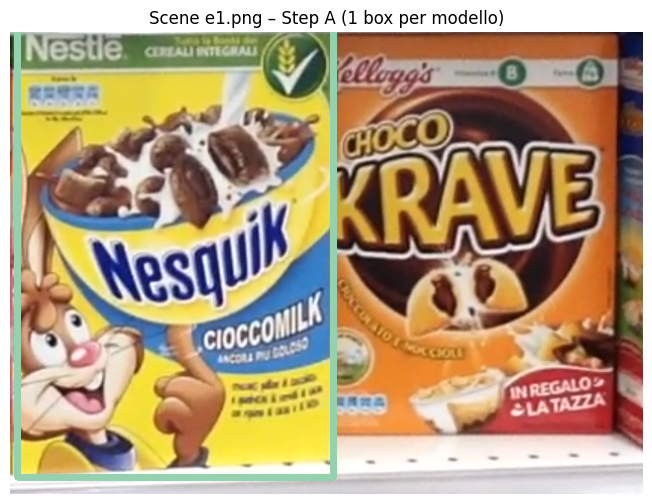

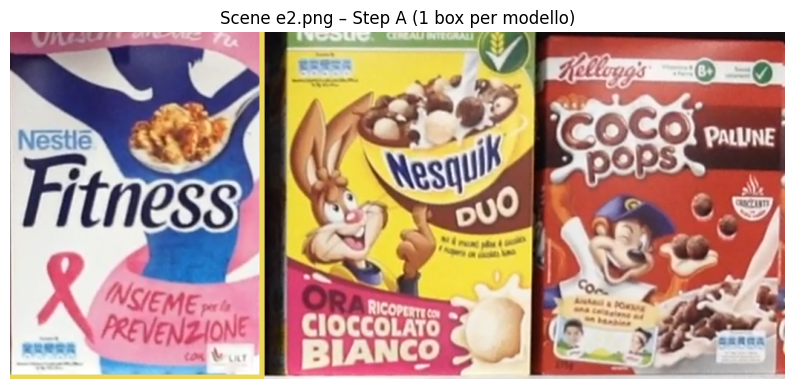

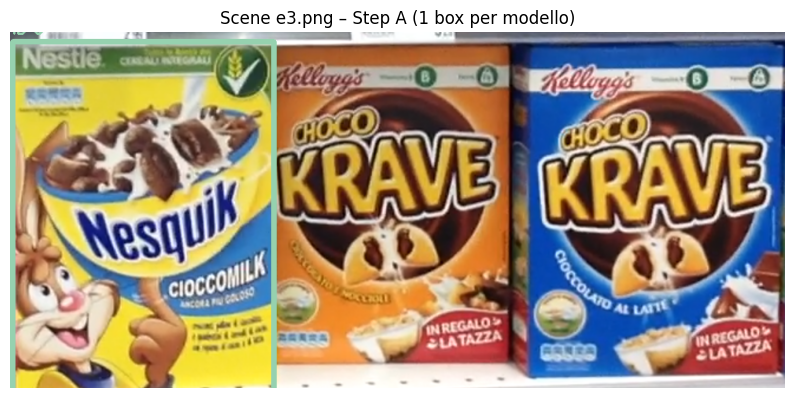

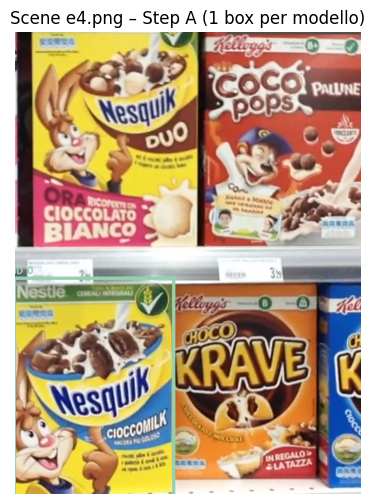

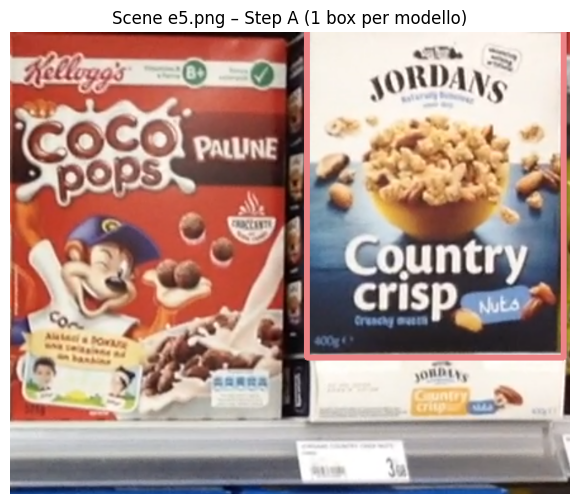

In [39]:
# --- Cella: Plot bounding box Step A ---
import matplotlib.pyplot as plt
import cv2, random
import numpy as np

# Fissa colori riproducibili
random.seed(0)
colors = {mid: tuple(map(int, np.random.choice(range(50,256), size=3)))
          for mid in model_ids}

for sf, img_color in scene_images.items():
    img_draw = img_color.copy()
    for mid in model_ids:
        for inst in detections[sf][mid]:
            x,y,w,h = inst["bbox"]
            col = colors[mid]
            # Disegna rettangolo e ID
            cv2.rectangle(img_draw, (x,y), (x+w,y+h), col, 5)
            cv2.putText(img_draw, f"ID {mid}", (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, col, 2)

    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
    plt.title(f"Scene {sf} – Step A (1 box per modello)")
    plt.axis('off')
    plt.show()
# --- Fine cella ---


In [40]:
# Stampa dei risultati finali
for sf in scene_images:
    print(f"Scene {sf}:")
    for mid in model_ids:
        inst_list = detections[sf][mid]
        count = len(inst_list)
        # Stampa numero di istanze per il modello
        print(f"  Model {mid}: {count} instances")
        # Stampa dettagli di ogni istanza
        for idx, inst in enumerate(inst_list, start=1):
            cx, cy = inst["position"]
            W = inst["width"]
            H = inst["height"]
            print(f"    Instance {idx}: {{position: ({cx}, {cy}), width: {W}, height: {H}}}")


Scene e1.png:
  Model 0: 1 instances
    Instance 1: {position: (163, 218), width: 313 px, height: 446 px}
  Model 1: 0 instances
  Model 11: 0 instances
  Model 19: 0 instances
  Model 24: 0 instances
  Model 25: 0 instances
  Model 26: 0 instances
Scene e2.png:
  Model 0: 0 instances
  Model 1: 0 instances
  Model 11: 0 instances
  Model 19: 0 instances
  Model 24: 1 instances
    Instance 1: {position: (167, 219), width: 343 px, height: 491 px}
  Model 25: 0 instances
  Model 26: 0 instances
Scene e3.png:
  Model 0: 1 instances
    Instance 1: {position: (169, 240), width: 332 px, height: 455 px}
  Model 1: 0 instances
  Model 11: 0 instances
  Model 19: 0 instances
  Model 24: 0 instances
  Model 25: 0 instances
  Model 26: 0 instances
Scene e4.png:
  Model 0: 1 instances
    Instance 1: {position: (162, 736), width: 329 px, height: 455 px}
  Model 1: 0 instances
  Model 11: 0 instances
  Model 19: 0 instances
  Model 24: 0 instances
  Model 25: 0 instances
  Model 26: 0 instances
